In [1]:
import pandas as pd
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, model_selection
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from scipy.stats import chisquare
import csv

import datetime as dt

np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dir_path = os.getcwd()
dir_path

area_cols = []
house_cols = []

with open('area.properties', 'r') as csvfile:
    file = csv.reader(csvfile, delimiter=' ')
    for row in file:
        area_cols.append(row[0])
        
with open('house.properties', 'r') as csvfile:
    file = csv.reader(csvfile, delimiter=' ')
    for row in file:
        house_cols.append(row[0])
        
print(len(area_cols))
print(len(house_cols))

89
12


In [3]:
def fix_num_cols(dframe, skiplist, dropcol=1):
    n = 0
    m = 0
    for col in dframe.columns.values:
        if col not in skiplist:
            if isinstance(dframe[col].dtype,((object))):
                try:
                    #dframe[col].fillna(dframe[col].mean(), inplace=True)
                    dframe[col].fillna(dframe[col].median(), inplace=True)
                    m+=1
                except:
                    print('error: ' + col)
                    if dropcol:
                        dframe.drop(col, inplace=True, axis=1)
                    else:
                        n+=1
                        #print(col)
                        #dframe[col] = dframe[col].astype('category').cat.codes
                        dframe[col].fillna('NUL', inplace=True)
    print(n)
    print(m)
    return dframe

In [5]:
if __name__ == "__main__":
    print (dt.datetime.now())
    dir_path = os.getcwd() + '/../../../data/all/'
    print (dir_path)
    df = pd.read_csv(dir_path + 'train.csv')
    df_macro = pd.read_csv(dir_path + 'macro.csv')

    df['price_length'] = [7.5 if cat > 6e6 and cat < 1e7 else len(str(cat)) for cat in df['price_doc'] ]
    
    df['price_length'] = [l if l < 8 else 8 for l in df['price_length']]
    
    df['price_cat'] = df['price_length'].astype('category').cat.codes
    
    df['quarter'] = df['timestamp'].apply(lambda x: pd.Timestamp(x).quarter)
    
    df.loc[df.price_cat == 4, 'price_cat'] = 3
    df_eda = pd.merge(df, df_macro, how='inner', on='timestamp', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
    
    null_yr = 9999.0
    yr = dt.datetime.now().year
    # take care of bad dates, dates too old, too far out into the future, or NaN. Set them all to 9999.0
    for i in df_eda['build_year'].index:
        if df_eda.loc[i, 'build_year'] < 1700 \
                or np.isnan(df_eda.loc[i, 'build_year']) \
                or df_eda.loc[i, 'build_year'] > yr:
            df_eda.loc[i, 'build_year'] = null_yr

    df_eda.drop(['price_length','id', 'timestamp'], inplace=True, axis=1)
    df_eda.loc[df_eda[df_eda['state'] == 33.0].index, 'state'] = 3.0
    
    print (dt.datetime.now())

2018-11-19 17:22:43.118781
/Users/chadleonard/Springboard/work/springboard/capstone/projects/capstone1_Sberbank/../../../data/all/
2018-11-19 17:22:55.079234


In [6]:
print (dt.datetime.now())
catlist = []
rest = []
m=0
skip = ['price_cat','id','timestamp','price_doc']
with open('cols.csv', 'r') as csvfile:
    file = csv.reader(csvfile, delimiter=' ')
    for row in file:
        cl = row[0].split(",")[1].replace('"','').replace("'",'').replace('(','')
        if cl not in skip:
            tp = row[0].split(",")[0]
            if tp == 'cat':
                m+=1
                catlist.append(cl)
            else:
                rest.append(cl)

df_cat = df_eda[catlist]           
for col in catlist:
    df_cat = pd.merge(df_cat, pd.get_dummies(df_cat[col].astype('category').cat.codes, prefix=col)\
                         ,left_index=True, right_index=True)
    df_cat.drop([col],inplace=True, axis=1)

scaler = preprocessing.StandardScaler()

df_new = fix_num_cols(df_eda[rest],skip)
scaler.fit(df_new)
df_new = pd.DataFrame(scaler.transform(df_new), columns=rest)
df_new = pd.merge(df_new, df_cat,left_index=True, right_index=True)
df_new['price_cat'] = df_eda['price_cat']

all_list = list(df_new)
    
newcat = list(df_cat.columns)   
x_list = [col for col in newcat + rest if col not in skip]
print(len(catlist))
print(len(newcat))
print(len(rest))
print(m)
print(len(x_list))
print(len(all_list))
print (dt.datetime.now())

2018-11-19 17:23:16.975625


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


0
327
62
408
327
62
735
736
2018-11-19 17:23:32.978226


In [28]:
minx = df_eda['full_sq'].describe()[3]
maxx = df_eda['full_sq'].describe()[7]
stdx = df_eda['full_sq'].describe()[2]
meanx = df_eda['full_sq'].describe()[1]
print(minx)
print(maxx)
print(stdx)
stddevs_from_mean = (maxx - meanx)/stdx
print('stdevs from the mean ' +str(stddevs_from_mean))
print(df_eda['full_sq'].describe())

0.0
5326.0
38.031487324106465
stdevs from the mean 138.616344024842
count    30471.000000
mean        54.214269
std         38.031487
min          0.000000
25%         38.000000
50%         49.000000
75%         63.000000
max       5326.000000
Name: full_sq, dtype: float64


In [39]:
df_eda['full_sq'].describe().loc['mean']

54.21426930524105

In [44]:
# get better understanding of columns
ln = df_eda.shape[0]
print(ln)
cols_w_outliers = []
for col in df_eda.columns:
    try:
        desc = df_eda[col].describe()
        #print(desc)
        minx = desc.loc['min']
        maxx = desc.loc['max']
        stdx = desc.loc['std']
        meanx = desc.loc['mean']
        stddevs_from_mean = (maxx - meanx)/stdx
        if stddevs_from_mean > 3:
            cols_w_outliers.append((stddevs_from_mean,col))
        #print('='*10)
    except:
        pass
print(len(cols_w_outliers))
sorted(cols_w_outliers, reverse=True)

30471
272


[(142.3638196084814, 'life_sq'),
 (138.616344024842, 'full_sq'),
 (71.02533672044444, 'kitch_sq'),
 (23.109653537330125, 'leisure_count_500'),
 (21.754321092397333, 'price_doc'),
 (20.871446422808138, 'cafe_count_1000_price_high'),
 (20.11275190625996, 'cafe_count_500_price_4000'),
 (20.063518722080325, 'num_room'),
 (19.55426274821817, 'church_synagogue_km'),
 (18.49609514027656, 'industrial_km'),
 (18.119636315409828, 'trc_sqm_500'),
 (16.760073361070585, 'cafe_count_500_price_1000'),
 (16.74381376031771, 'public_healthcare_km'),
 (16.541779133085225, 'fitness_km'),
 (16.302862308561995, 'cafe_count_500_price_high'),
 (16.223416670798166, 'leisure_count_1000'),
 (15.457743726838112, 'max_floor'),
 (15.17143422396022, 'office_sqm_1000'),
 (15.0803851790294, 'preschool_km'),
 (15.06493450496005, 'school_km'),
 (15.030425493126923, 'additional_education_km'),
 (14.565806213867646, 'office_count_500'),
 (14.509518796291909, 'big_church_km'),
 (14.265226150099384, 'mosque_count_500'),
 (1

In [54]:
d = defaultdict(int)
for a in cols_w_outliers:
    mn = df_eda[a[1]].mean()
    std = df_eda[a[1]].std()
    for val in df_eda[a[1]]:
        v = abs(val - mn)/std
        if v > 3:
            d[a[1]] += 1
f = [(v,k )for k,v in d.items()]
sorted(f,reverse=True)
        

[(2683, 'mosque_count_2000'),
 (1373, 'mortgage_rate'),
 (1351, 'cafe_count_5000_price_high'),
 (1315, 'male_f'),
 (1315, 'full_all'),
 (1315, 'female_f'),
 (1315, '16_29_male'),
 (1315, '16_29_female'),
 (1315, '16_29_all'),
 (1308, 'cafe_count_5000_price_4000'),
 (1301, 'park_km'),
 (1293, 'build_count_before_1920'),
 (1285, 'big_church_count_5000'),
 (1278, 'cafe_count_5000_price_2500'),
 (1276, 'church_count_5000'),
 (1258, 'leisure_count_5000'),
 (1252, 'cafe_count_5000_price_500'),
 (1239, 'office_sqm_2000'),
 (1228, 'cafe_count_5000'),
 (1218, 'metro_min_avto'),
 (1218, 'cafe_count_5000_price_1000'),
 (1211, 'cafe_count_5000_na_price'),
 (1190, 'cafe_count_5000_price_1500'),
 (1186, 'additional_education_raion'),
 (1185, 'office_sqm_5000'),
 (1183, 'office_count_5000'),
 (1153, 'office_sqm_3000'),
 (1152, 'mosque_count_1500'),
 (1136, 'office_sqm_1500'),
 (1116, 'mosque_km'),
 (1085, 'university_top_20_raion'),
 (1056, 'office_raion'),
 (1056, 'build_count_brick'),
 (1053, 'trc_

In [19]:
# get better understanding of columns
ln = df_eda.shape[0]
print(ln)
cols_with_nulls = []
for col in df_eda.columns:
    #print(col)
    collen = df_eda[col].describe()[0]
    #print(collen)
    if collen < ln:
        cols_with_nulls.append((col,collen))
    #print('='*10)
print(len(cols_with_nulls))
cols_with_nulls

30471
92


[('life_sq', 24088.0),
 ('floor', 30304.0),
 ('max_floor', 20899.0),
 ('material', 20899.0),
 ('num_room', 20899.0),
 ('kitch_sq', 20899.0),
 ('state', 16912.0),
 ('preschool_quota', 23783.0),
 ('school_quota', 23786.0),
 ('hospital_beds_raion', 16030.0),
 ('raion_build_count_with_material_info', 25480.0),
 ('build_count_block', 25480.0),
 ('build_count_wood', 25480.0),
 ('build_count_frame', 25480.0),
 ('build_count_brick', 25480.0),
 ('build_count_monolith', 25480.0),
 ('build_count_panel', 25480.0),
 ('build_count_foam', 25480.0),
 ('build_count_slag', 25480.0),
 ('build_count_mix', 25480.0),
 ('raion_build_count_with_builddate_info', 25480.0),
 ('build_count_before_1920', 25480.0),
 ('build_count_1921-1945', 25480.0),
 ('build_count_1946-1970', 25480.0),
 ('build_count_1971-1995', 25480.0),
 ('build_count_after_1995', 25480.0),
 ('metro_min_walk', 30446.0),
 ('metro_km_walk', 30446.0),
 ('railroad_station_walk_km', 30446.0),
 ('railroad_station_walk_min', 30446.0),
 ('ID_railroad_s

In [28]:
#pd.crosstab(a, [b, c], rownames=['a'], colnames=['b', 'c'])
y = df_eda['price_cat']
#b = df_eda['material']
c = df_eda['material']
x_tab = pd.crosstab(y, [c], rownames=['price_cat'], colnames=['state']).apply(lambda r: r/r.sum(), axis=1)
x_tab

state,1.0,2.0,3.0,4.0,5.0,6.0
price_cat,,,,,,
0,0.545455,0.207792,0.000000,0.038961,0.168831,0.038961
1,0.696302,0.128780,0.000000,0.059872,0.070233,0.044814
2,0.705423,0.125212,0.000113,0.047209,0.093173,0.028869
3,0.581345,0.217462,0.000000,0.115781,0.038503,0.046909


In [31]:
chsq = chisquare(x_tab)

In [72]:
with open('cols.csv', 'w') as f:
    writer = csv.writer(f)
    for col in sorted(coltypes):
        writer.writerows([col])

In [7]:
df_new.head()

,ID_railroad_station_walk,additional_education_km,apartment_build,area_m,average_provision_of_build_contract,average_provision_of_build_contract_moscow,balance_trade,balance_trade_growth,basketball_km,baths_share,...,unemployment_2,unemployment_3,unemployment_4,university_top_20_raion_0,university_top_20_raion_1,university_top_20_raion_2,university_top_20_raion_3,water_1line_0,water_1line_1,price_cat
0,-1.363813,-0.249330,-5.857459,-0.544788,-1.774799,1.093412,-0.836632,-0.681054,-0.235595,6.282208,...,0,0,0,1,0,0,0,1,0,1
1,-1.327783,-0.167851,-5.857459,-0.390702,-1.774799,1.093412,-0.836632,-0.681054,-0.672067,6.282208,...,0,0,0,1,0,0,0,1,0,1
2,-1.291753,-0.613638,-5.857459,-0.622239,-1.774799,1.093412,-0.836632,-0.681054,-0.525425,6.282208,...,0,0,0,1,0,0,0,1,0,1
3,-1.255724,-0.285556,-5.857459,-0.245700,-1.774799,1.093412,-0.866722,-0.681054,0.025245,6.282208,...,0,0,0,1,0,0,0,1,0,3
4,-1.219694,-0.339201,-5.857459,-0.448374,-1.774799,1.093412,-0.866722,-0.681054,-0.830288,6.282208,...,0,0,0,0,0,1,0,1,0,3


In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_new[x_list], \
                                                                df_new['price_cat'], test_size=0.3)
X_train.shape

(21329, 735)

In [171]:
for col in X_train.columns:
    pass

In [174]:
print (dt.datetime.now())
pipe = Pipeline([
  #('fs', SelectFromModel(LogisticRegression(multi_class='ovr'))),
  ('clf', RandomForestClassifier())
])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [500]  }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=5)

pipe_est_cv.fit(X_train, y_train)
print(pipe_est_cv.best_params_)
print(pipe_est_cv.score(X_test, y_test))
print (dt.datetime.now())

2018-11-17 14:10:53.509799
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__n_estimators=500 ...........................................
[CV] clf__n_estimators=500 ...........................................
[CV] clf__n_estimators=500 ...........................................
[CV] clf__n_estimators=500 ...........................................
[CV] clf__n_estimators=500 ...........................................
[CV] .. clf__n_estimators=500, score=0.7597280825128926, total= 1.3min
[CV] .. clf__n_estimators=500, score=0.7723863103609939, total= 1.3min
[CV] .. clf__n_estimators=500, score=0.7648851383028599, total= 1.3min
[CV] ... clf__n_estimators=500, score=0.763244256915143, total= 1.3min


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min


[CV] .. clf__n_estimators=500, score=0.7578527894983591, total= 1.4min


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.5min finished


{'clf__n_estimators': 500}
0.7731349814045066
2018-11-17 14:13:39.186551


In [ ]:
# First XGBoost Classifier model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# load data

print (dt.datetime.now())
pipe = Pipeline([
      # ('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', XGBClassifier()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [200], \
              "clf__objective": ['multi:softmax', 'multi:softprob'] , "clf__max_depth": [10]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, \
                                           scoring='accuracy', verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-17 17:37:07.592485
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax 
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax, score=0.8077824660103141, total=17.7min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax, score=0.8105954055321144, total=17.8min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax, score=0.7991092358180966, total=17.6min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax, score=0.7993436474449133, total=17.7min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob 


In [160]:
print(pipe_est_cv.score(X_test, y_test))

1.0


Possible values for **palette** are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, 
    CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, 
    Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG,
    PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, 
    RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, 
    Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, 
    YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, 
    bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, 
    copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, 
    gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, 
    gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, 
    hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, 
    nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, 
    rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, 
    tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, 
    viridis_r, vlag, vlag_r, winter, winter_r

[Text(0.5,1,'Distribution of build year with Bad Dates')]

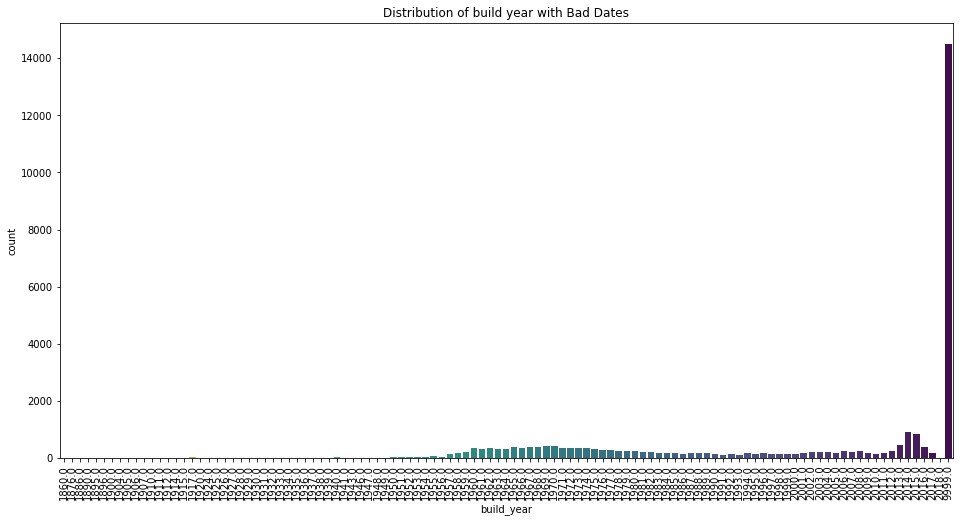

In [4]:
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
by_df = df_eda.sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'],palette="viridis_r")
ax.set(title='Distribution of build year with Bad Dates')

In [108]:
#l = list(set(df_eda.loc[not_ind].sort_values(by=['build_year'])['build_year']))
l = list(set(df_eda.loc[not_ind].sort_values(by=['build_year'])['build_year']))
v=0
al = []
a2 = []
for a in range(5,len(l),5):
    #print(a)
    al.append(l[v:a])
    a2.append(l[v:a])
    v=a
al.append(l[-5:])
a2.append(l[-5:])
al.append([9999.0])

In [109]:
a2

[[1860.0, 1876.0, 1886.0, 1890.0, 1895.0],
 [1896.0, 1900.0, 1904.0, 1905.0, 1906.0],
 [1907.0, 1910.0, 1911.0, 1912.0, 1914.0],
 [1915.0, 1917.0, 1920.0, 1924.0, 1925.0],
 [1926.0, 1927.0, 1928.0, 1929.0, 1930.0],
 [1931.0, 1932.0, 1933.0, 1934.0, 1935.0],
 [1936.0, 1937.0, 1938.0, 1939.0, 1940.0],
 [1941.0, 1943.0, 1946.0, 1947.0, 1948.0],
 [1949.0, 1950.0, 1951.0, 1952.0, 1953.0],
 [1954.0, 1955.0, 1956.0, 1957.0, 1958.0],
 [1959.0, 1960.0, 1961.0, 1962.0, 1963.0],
 [1964.0, 1965.0, 1966.0, 1967.0, 1968.0],
 [1969.0, 1970.0, 1971.0, 1972.0, 1973.0],
 [1974.0, 1975.0, 1976.0, 1977.0, 1978.0],
 [1979.0, 1980.0, 1981.0, 1982.0, 1983.0],
 [1984.0, 1985.0, 1986.0, 1987.0, 1988.0],
 [1989.0, 1990.0, 1991.0, 1992.0, 1993.0],
 [1994.0, 1995.0, 1996.0, 1997.0, 1998.0],
 [1999.0, 2000.0, 2001.0, 2002.0, 2003.0],
 [2004.0, 2005.0, 2006.0, 2007.0, 2008.0],
 [2009.0, 2010.0, 2011.0, 2012.0, 2013.0],
 [2014.0, 2015.0, 2016.0, 2017.0, 2018.0]]

In [129]:
n=0
tl = []
for yr in df_eda['build_year'].values:
    for a in al:
        if yr in a:
            tl.append(sum(a))

n=0
t2 = []
for yr in df_eda['build_year'].values:
    for a in a2:
        if yr in a:
            t2.append(sum(a))


ser = pd.Series(sorted(tl)).astype('category').cat.codes
ser[ser == 18] = 99
ser[ser == 19] = 18
ser[ser == 20] = 19
ser[ser == 21] = 20
ser[ser == 22] = 21
ser[ser == 99] = 22
ser2 = pd.Series(sorted(t2)).astype('category').cat.codes
ser2.shape

(15960,)

In [130]:
ser[ser == 18]

25101    18
25102    18
25103    18
25104    18
25105    18
25106    18
25107    18
25108    18
25109    18
25110    18
25111    18
25112    18
25113    18
25114    18
25115    18
25116    18
25117    18
25118    18
25119    18
25120    18
25121    18
25122    18
25123    18
25124    18
25125    18
25126    18
25127    18
25128    18
25129    18
25130    18
         ..
25910    18
25911    18
25912    18
25913    18
25914    18
25915    18
25916    18
25917    18
25918    18
25919    18
25920    18
25921    18
25922    18
25923    18
25924    18
25925    18
25926    18
25927    18
25928    18
25929    18
25930    18
25931    18
25932    18
25933    18
25934    18
25935    18
25936    18
25937    18
25938    18
25939    18
Length: 839, dtype: int8

In [131]:
desc_list = []
n=0
for a in al[:-1]:
    desc_list.append(str(int(a[0]))+'_to_'+str(int(a[-1])))
desc_list.append("bad_years")
desc_list

desc_list2 = []
for a in a2:
    desc_list2.append(str(int(a[0]))+'_to_'+str(int(a[-1])))
desc_list2

['1860_to_1895',
 '1896_to_1906',
 '1907_to_1914',
 '1915_to_1925',
 '1926_to_1930',
 '1931_to_1935',
 '1936_to_1940',
 '1941_to_1948',
 '1949_to_1953',
 '1954_to_1958',
 '1959_to_1963',
 '1964_to_1968',
 '1969_to_1973',
 '1974_to_1978',
 '1979_to_1983',
 '1984_to_1988',
 '1989_to_1993',
 '1994_to_1998',
 '1999_to_2003',
 '2004_to_2008',
 '2009_to_2013',
 '2014_to_2018']

[Text(0.5,1,'Build year counts with Bad Years and NULLs')]

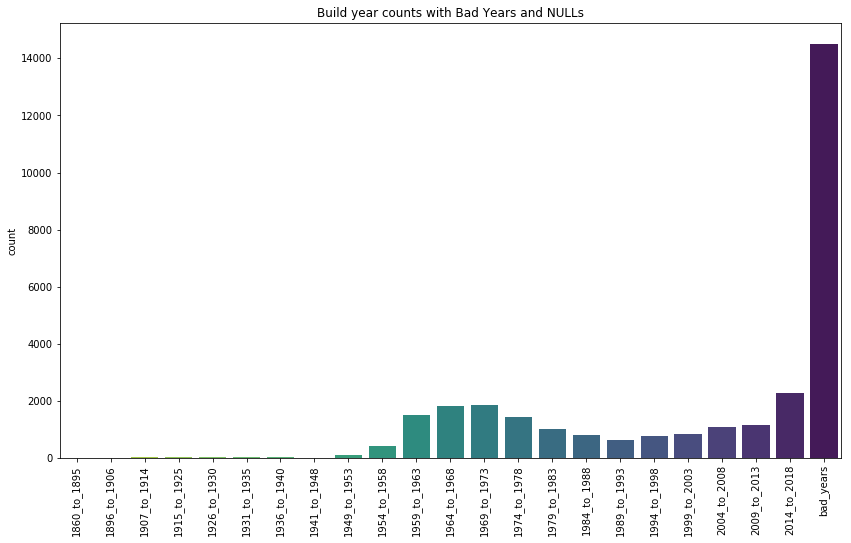

In [132]:
f, ax = plt.subplots(figsize=(14, 8))
plt.xticks(rotation='90')
sns.countplot(x=ser,palette="viridis_r")
ax.set_xticklabels(desc_list)
ax.set(title='Build year counts with Bad Years and NULLs')


[Text(0.5,1,'Build year counts without Bad Years and NULLs')]

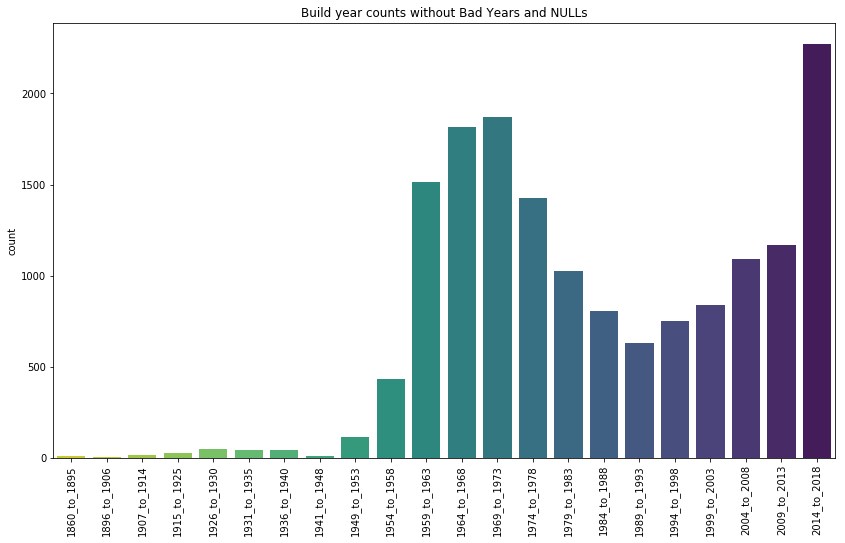

In [119]:
f, ax = plt.subplots(figsize=(14, 8))
plt.xticks(rotation='90')
sns.countplot(x=ser2,palette="viridis_r")
ax.set_xticklabels(desc_list2)
ax.set(title='Build year counts without Bad Years and NULLs')


15960


[Text(0.5,1,'Distribution of build years without Bad Dates')]

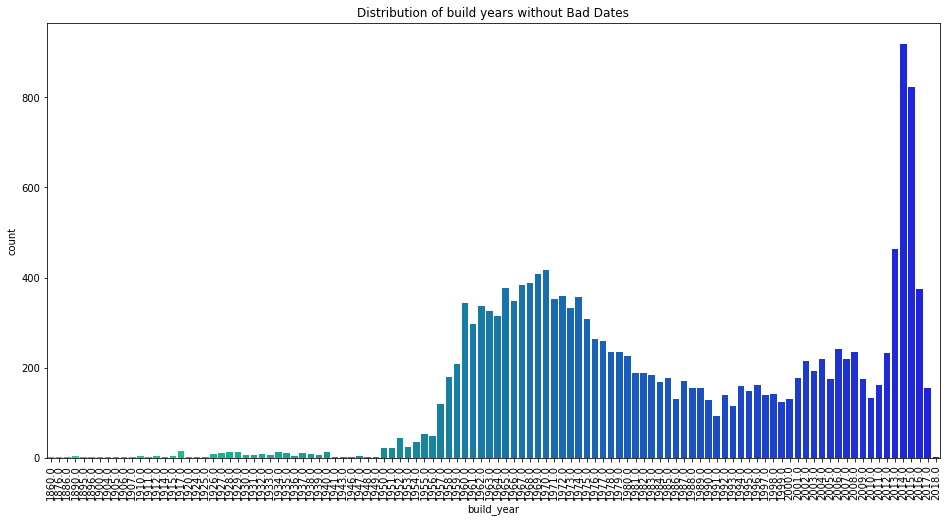

In [5]:
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
not_ind = df_eda[(df_eda['build_year'] != null_yr)].index
print(len(not_ind))
by_df = df_eda.loc[not_ind].sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'],palette="winter_r")
ax.set(title='Distribution of build years without Bad Dates')

15777


[Text(0.5,1,'Distribution of build years 1940 to Present')]

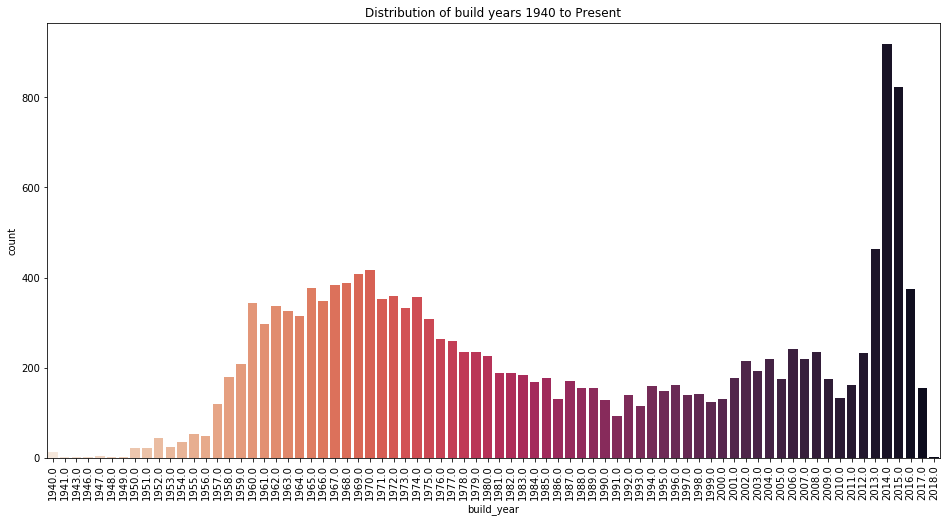

In [19]:
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
not_ind = df_eda[((df_eda['build_year'] != null_yr)) & (df_eda['build_year'] >= 1940.0)].index
print(len(not_ind))
by_df = df_eda.loc[not_ind].sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'],palette="rocket_r")
ax.set(title='Distribution of build years 1940 to Present')

183


[Text(0.5,1,'Distribution of build years before 1940')]

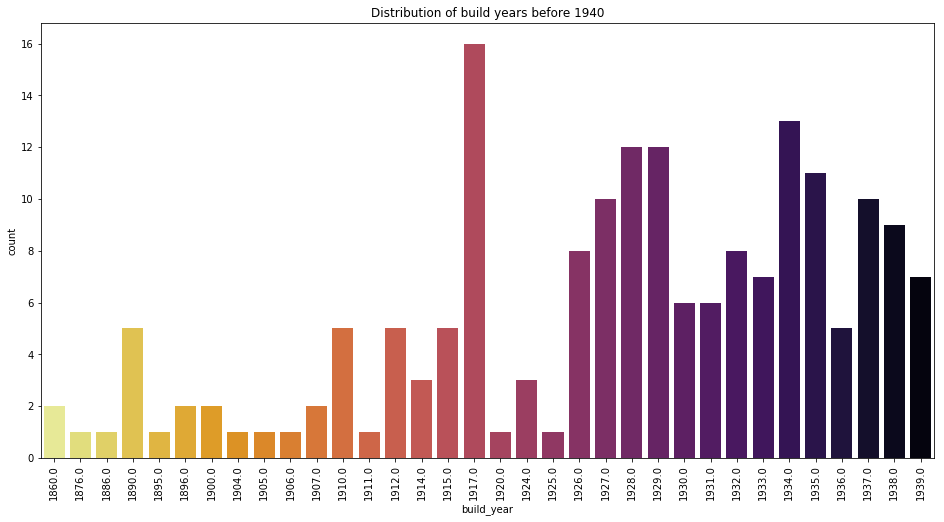

In [17]:
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
not_ind = df_eda[(df_eda['build_year'] < 1940.0)].index
print(len(not_ind))
by_df = df_eda.loc[not_ind].sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'],palette="inferno_r")
ax.set(title='Distribution of build years before 1940')

In [128]:
df_eda['build_year'].value_counts()
pass

In [51]:
dt.datetime.now().year
for k in bad_yr.keys():
    df_eda[df_eda['build_year'] == k] = null_yr

In [6]:
print(df_eda['build_year'].max())
print(df_eda['build_year'].min())
df_eda['build_year'].value_counts()
pass

9999.0
1860.0


27744


[Text(0.5,1,'Distribution of full square meters 0 to 79 units')]

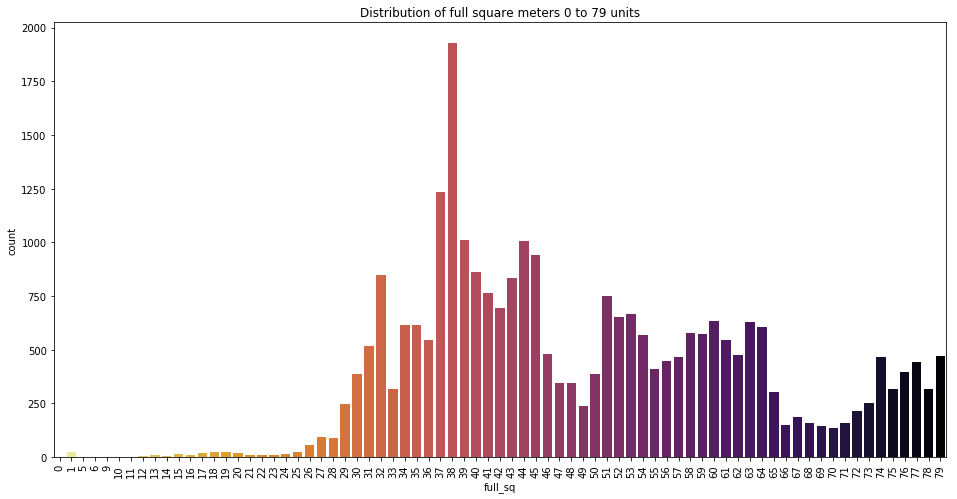

In [21]:
#df_eda['full_sq'].value_counts()
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
ind = df_eda[df_eda['full_sq'] < 80 ].index
print(len(ind))
by_df = df_eda.loc[ind].sort_values(by=['full_sq'])
sns.countplot(x=by_df['full_sq'],palette="inferno_r")
ax.set(title='Distribution of full square meters 0 to 79 units')

2727


[Text(0.5,1,'Distribution of full square meters greater than 79 units')]

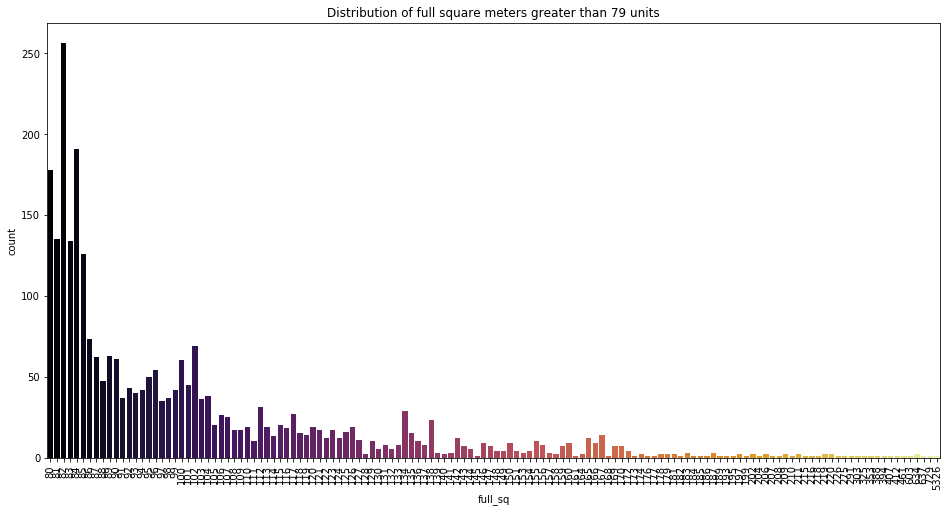

In [22]:
#df_eda['full_sq'].value_counts()
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
ind = df_eda[df_eda['full_sq'] > 79 ].index
print(len(ind))
by_df = df_eda.loc[ind].sort_values(by=['full_sq'])
sns.countplot(x=by_df['full_sq'],palette="inferno")
ax.set(title='Distribution of full square meters greater than 79 units')

In [14]:
print(df_eda['full_sq'].max())
print(df_eda['full_sq'].min())
print(df_eda['full_sq'].mean())

5326
0
54.21426930524105


In [24]:
print(sum(df_eda['full_sq'].isnull()))
print(sum(df_eda['life_sq'].isnull()))
print(sum(df_eda['kitch_sq'].isnull()))

0
6383
9572


In [26]:
df_eda['life_sq'].value_counts(dropna=False)

NaN       6383
 19.0     2138
 30.0     1565
 18.0     1544
 20.0     1208
 28.0     1067
 29.0      804
 32.0      701
 27.0      700
 17.0      699
 44.0      695
 43.0      626
 45.0      626
 38.0      534
 31.0      520
 21.0      518
 34.0      503
 33.0      461
 37.0      402
 1.0       390
 46.0      386
 22.0      379
 26.0      373
 40.0      367
 42.0      346
 23.0      317
 41.0      293
 16.0      282
 39.0      280
 36.0      263
          ... 
 189.0       1
 802.0       1
 637.0       1
 166.0       1
 325.0       1
 162.0       1
 163.0       1
 7.0         1
 349.0       1
 232.0       1
 191.0       1
 109.0       1
 130.0       1
 176.0       1
 259.0       1
 179.0       1
 111.0       1
 174.0       1
 136.0       1
 172.0       1
 458.0       1
 150.0       1
 301.0       1
 426.0       1
 143.0       1
 145.0       1
 435.0       1
 157.0       1
 195.0       1
 147.0       1
Name: life_sq, Length: 176, dtype: int64

**IMPORTANT NOTES ABOUT FEATURES**

THESE ARE SOME OF THE SUMMARY NOTES GAINED FROM KAGGLE DISCUSSIONS, QUESTIONS AND ANSWERS FROM SBERBANK

- CHECK LIFE SQ, FULL SQ, KITCH SQ FOR CONSISTENCY (DONE)

- BUILD YEAR CAN BE IN FUTURE - PRE INVESTMENT TYPE (DONE)

- BUILD YEAR 0 AND 1 ARE MISTAKES (DONE)

- CHECK TRAIN AND TEST PRODUCT TYPES (DONE)

- CHECK NUM OF ROOMS FOR CONSISTENCY (DONE)

- MATERIAL EXPLAINED: 1 - panel, 2 - brick, 3 - wood, 4 - mass concrete, 5 - breezeblock, 6 - mass concrete plus brick

- STATE EXPLAINED: 4 BEST 1 WORST

- KITCHEN INCLUDED IN LIFE SQ CHECK INCONSISTENCY (DONE)

- FULL SQ > LIFE SQ (MOST PROBABLY) (DONE)

- KM DISTANCES ARE AIRLINE DISTANCES

- RAION POPUL AND FULL ALL ARE SAME CALC FROM DIFF SOURCES

**website:**    https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/35755

https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis

https://www.kaggle.com/agzamovr/a-very-extensive-exploratory-analysis-in-python

https://www.kaggle.com/keremt/very-extensive-cleaning-by-sberbank-discussions


**Feature Engineering**

Yes, just one feature and you might get 0.03-0.045 jump in your score.

**areadiff = fullsq - kitch_sq, this feature.**



I don't know how many of you found out about this feature, because all the public kernels didn't mention this feature and even still the top participants haven't talked about this. 

In all the public kernels, i saw that:
1.  fullsq was divided either by lifesq or by kitchsq, but no one seemed to be interested in 
2. taking the difference between fullsq and lifesq, which would not only tell us the true lifesq but also it greatly characterises the missing or false fullsq values by giving it negative sign, if fullsq is less than kitchsq. 
3. This feature brought me from 32.00 to 31.603 on Pub.LB and gave me 31.710 on Pvt.LB. This feature had the second highest correlation(even greater than fullsq) after num_room(i think!) with the target variable. You can make this feature in your kernel and verify everything what i said.

In [27]:
df_eda['target'] = pd.Series([0 if t != 0 else 1 for t in df_eda['price_cat'] ])
df_eda['target'].value_counts()

0    30238
1      233
Name: target, dtype: int64

In [36]:
df_eda['target_1'] = pd.Series([0 if t != 1 else 1 for t in df_eda['price_cat'] ])
df_eda['target_1'].value_counts()

0    16721
1    13750
Name: target_1, dtype: int64

In [40]:
df_eda['target_2'] = pd.Series([0 if t != 2 else 1 for t in df_eda['price_cat'] ])
df_eda['target_2'].value_counts()

0    18793
1    11678
Name: target_2, dtype: int64

In [4]:
df_eda['target_3'] = pd.Series([0 if t != 3 else 1 for t in df_eda['price_cat'] ])
df_eda['target_3'].value_counts()

0    25661
1     4810
Name: target_3, dtype: int64

In [9]:
av = df_eda['target_2'].value_counts()
weights = dict()
print(av)
for a in av.index:
    print(a)
    weights.update({a: av.loc[a]/sum(av)})
weights

0    18793
1    11678
Name: target_2, dtype: int64
0
1


{0: 0.6167503527944603, 1: 0.38324964720553967}

In [28]:
df_eda['areadiff'] = df_eda['full_sq'] - df_eda['life_sq']
df_eda['areadiff'].head()

0    16.0
1    15.0
2    14.0
3    39.0
4     0.0
Name: areadiff, dtype: float64

In [29]:
skip = ['timestamp', 'price_doc', 'price_cat','target','target_1','target_2','target_3']
df_train = fix_num_cols(df_eda, skip, 0)
#print(len(df_train.columns.values))
#df_train = fix_num_cols(df_train, skip, 0)
df_train = pd.get_dummies(df_train)

print(len(df_train.columns.values))
df_train.head()

error: product_type
error: sub_area
error: culture_objects_top_25
error: thermal_power_plant_raion
error: incineration_raion
error: oil_chemistry_raion
error: radiation_raion
error: railroad_terminal_raion
error: big_market_raion
error: nuclear_reactor_raion
error: detention_facility_raion
error: water_1line
error: big_road1_1line
error: railroad_1line
error: ecology
error: child_on_acc_pre_school
error: modern_education_share
error: old_education_build_share
18
372
565


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,"child_on_acc_pre_school_7,311",child_on_acc_pre_school_NUL,"modern_education_share_90,92","modern_education_share_93,08","modern_education_share_95,4918",modern_education_share_NUL,"old_education_build_share_23,14","old_education_build_share_25,47","old_education_build_share_8,2517",old_education_build_share_NUL
0,43,27.0,4.0,12.0,1.0,9999.0,2.0,6.0,2.0,6.407578e+06,...,0,0,0,0,0,1,0,0,0,1
1,34,19.0,3.0,12.0,1.0,9999.0,2.0,6.0,2.0,9.589337e+06,...,0,0,0,0,0,1,0,0,0,1
2,43,29.0,2.0,12.0,1.0,9999.0,2.0,6.0,2.0,4.808270e+06,...,0,0,0,0,0,1,0,0,0,1
3,89,50.0,9.0,12.0,1.0,9999.0,2.0,6.0,2.0,1.258354e+07,...,0,0,0,0,0,1,0,0,0,1
4,77,77.0,4.0,12.0,1.0,9999.0,2.0,6.0,2.0,8.398461e+06,...,0,0,0,0,0,1,0,0,0,1


In [41]:
#skip = ['timestamp', 'price_doc', 'price_cat','target', 'target_1']
tgt = 'target_2'
df_train[tgt] = df_eda[tgt]
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train.loc[:,~df_train.columns.isin(skip)], \
                                                                df_train[tgt], test_size=0.3)
X_train.shape

(21329, 562)

In [61]:
# target 2
print (dt.datetime.now())
pipe = Pipeline([
  ('fs', SelectFromModel(LogisticRegression(multi_class='ovr'))),
  ('clf', RandomForestClassifier())
])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [500]  }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
print(pipe_est_cv.best_params_)
print(pipe_est_cv.score(X_test, y_test))
print (dt.datetime.now())

2018-11-15 16:01:08.795797
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__n_estimators=500 ...........................................
[CV] clf__n_estimators=500 ...........................................
[CV] .. clf__n_estimators=500, score=0.6413502109704642, total=  35.7s
[CV] clf__n_estimators=500 ...........................................
[CV] .. clf__n_estimators=500, score=0.7845757149554617, total=  41.8s
[CV] clf__n_estimators=500 ...........................................
[CV] .. clf__n_estimators=500, score=0.6324425691514299, total=  38.6s
[CV] clf__n_estimators=500 ...........................................
[CV] .. clf__n_estimators=500, score=0.6383028598218472, total=  39.0s
[CV] ... clf__n_estimators=500, score=0.636896390060947, total=  33.7s


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.0min finished


{'clf__n_estimators': 500}
0.7933712535550208
2018-11-15 16:03:51.122283


In [66]:
X_train['old_education_build_share_NUL']
pass

In [69]:
fs = pipe_est_cv.best_estimator_.named_steps['fs']
feature_names_example = [X_train.columns]
#selected_features = fs.transform(feature_names_example)

#print (selected_features[0])
print(fs.get_params)

<bound method BaseEstimator.get_params of SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None)>


In [39]:
# target 1
print (dt.datetime.now())
clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(multi_class='ovr', n_jobs=2))),
  ('classification', RandomForestClassifier())
])
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print (dt.datetime.now())

2018-11-15 15:43:18.562866


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


0.831109166484358
2018-11-15 15:43:41.739833


In [31]:
# target 0
print (dt.datetime.now())
clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(multi_class='ovr', n_jobs=2))),
  ('classification', RandomForestClassifier())
])
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print (dt.datetime.now())

2018-11-15 15:36:28.652110


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


0.9924524174141326
2018-11-15 15:36:45.347673


In [35]:
for col in X_train.columns:
    if "price" in col:
        print(col)

cafe_sum_500_min_price_avg
cafe_sum_500_max_price_avg
cafe_avg_price_500
cafe_count_500_na_price
cafe_count_500_price_500
cafe_count_500_price_1000
cafe_count_500_price_1500
cafe_count_500_price_2500
cafe_count_500_price_4000
cafe_count_500_price_high
cafe_sum_1000_min_price_avg
cafe_sum_1000_max_price_avg
cafe_avg_price_1000
cafe_count_1000_na_price
cafe_count_1000_price_500
cafe_count_1000_price_1000
cafe_count_1000_price_1500
cafe_count_1000_price_2500
cafe_count_1000_price_4000
cafe_count_1000_price_high
cafe_sum_1500_min_price_avg
cafe_sum_1500_max_price_avg
cafe_avg_price_1500
cafe_count_1500_na_price
cafe_count_1500_price_500
cafe_count_1500_price_1000
cafe_count_1500_price_1500
cafe_count_1500_price_2500
cafe_count_1500_price_4000
cafe_count_1500_price_high
cafe_sum_2000_min_price_avg
cafe_sum_2000_max_price_avg
cafe_avg_price_2000
cafe_count_2000_na_price
cafe_count_2000_price_500
cafe_count_2000_price_1000
cafe_count_2000_price_1500
cafe_count_2000_price_2500
cafe_count_2000_

In [18]:
clf = LogisticRegression(multi_class='ovr', n_jobs=2).fit(X_train, y_train)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
X_new.shape

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


(21329, 85)

In [23]:
model.fit(X_new, y_test)

NotFittedError: Since 'prefit=True', call transform directly

In [21]:
X_train = df_train.loc[:,~df_train.columns.isin(skip)]
y_train = df_train['target_2']
X_train.shape

(30471, 562)

In [26]:
y_tn = df_eda['price_doc']

In [28]:
corlist_cont = []
corlist_discrete = []

for col in X_train.columns.values:
    if col not in skip:
        X_corr = np.corrcoef(X_train[col],y_train)
        X_disc = np.corrcoef(X_train[col],y_tn)
        corlist_cont.append((np.abs(X_corr[1][0]), col))
        corlist_discrete.append((np.abs(X_disc[1][0]), col))
corlist_discrete = sorted(corlist_discrete, reverse=True)
corlist_cont = sorted(corlist_cont, reverse=True)

for a in corlist_discrete:
    if 'areadiff' in a:
        print(a)
        
for a in corlist_cont:
    if 'areadiff' in a:
        print(a)

(0.27909329382102877, 'areadiff')
(0.011558935835008348, 'areadiff')


In [221]:
# Logistic Regression Multi-class Classifier ==> class 3
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', LogisticRegression(multi_class='ovr', n_jobs=2)) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__fit_intercept": [False]  , "clf__solver": ['liblinear', 'sag'] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-02 19:34:01.323956
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__fit_intercept=False, clf__solver=liblinear .................
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9052977027660571, total=  47.4s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9085794655414908, total=  53.1s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9104547585560244, total=  32.9s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9106891701828411, total=  52.3s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8595874355368026, total=  10.4s
[CV] clf__fit_intercept=False, clf__solver=sag .......................
[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9144397562119081, total=  45.4s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8534927332395686, total=  10.1s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8448195030473511, total=   9.7s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] clf__fit_intercept=False, clf__solver=sag .......................
[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8384903891233005, total=   9.6s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.843413033286451, total=   9.5s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.5min finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


{'clf__fit_intercept': False, 'clf__solver': 'liblinear'}
0.9098921706516643
[0.91575925 0.85757487]
[0.90989217 0.84796062]
2018-11-02 19:37:14.090918


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [212]:
# Logistic Regression Multi-class Classifier ==> class 2
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', LogisticRegression(multi_class='ovr', n_jobs=2)) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__fit_intercept": [False]  , "clf__solver": ['liblinear', 'sag'] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-02 19:13:28.620684
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__fit_intercept=False, clf__solver=liblinear .................
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.6289263947491796, total=  18.9s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.6108766994842945, total=  19.7s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.6082981715893109, total=  19.7s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.6169714017815283, total=  20.8s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.6247069854664792, total=  10.3s
[CV] clf__fit_intercept=False, clf__solver=sag .......................
[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.6148616971401781, total=  18.6s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.6022034692920769, total=  10.7s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.6118143459915611, total=  10.1s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.616502578527895, total=   9.9s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.6108766994842945, total=   9.7s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.3min finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


{'clf__fit_intercept': False, 'clf__solver': 'liblinear'}
0.6159868729488983
[0.64286468 0.63907871]
[0.61598687 0.61322082]
2018-11-02 19:15:19.046551


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [214]:
# Logistic Regression Multi-class Classifier ==> class 1
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', LogisticRegression(multi_class='ovr', n_jobs=2, class_weight=weights)) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__fit_intercept": [False]  , "clf__solver": ['liblinear', 'sag'] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-02 19:16:42.760329
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__fit_intercept=False, clf__solver=liblinear .................
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.829817158931083, total=  30.6s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.8195030473511487, total=  32.8s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.8248945147679325, total=  19.6s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.8347398030942335, total=  27.5s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8185654008438819, total=  10.2s
[CV] clf__fit_intercept=False, clf__solver=sag .......................
[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.8288795124238162, total=  21.2s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.813173933427098, total=  10.2s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8134083450539147, total=  10.2s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8227848101265823, total=  10.1s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8263009845288326, total=   9.9s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.6min finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


{'clf__fit_intercept': False, 'clf__solver': 'liblinear'}
0.8275668073136427
[0.8395124  0.82659556]
[0.82756681 0.81884669]
2018-11-02 19:18:49.943877


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [219]:
# Logistic Regression Multi-class Classifier ==> class 0
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', LogisticRegression(multi_class='ovr', n_jobs=2, class_weight=weights)) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__fit_intercept": [False]  , "clf__solver": ['liblinear', 'sag'] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-02 19:24:02.339697
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__fit_intercept=False, clf__solver=liblinear .................
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.8940459446788561, total=  29.5s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9102203469292077, total=  48.7s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9104547585560244, total=  32.2s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9027191748710736, total=  42.0s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8105954055321144, total=  10.0s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8255977496483825, total=  10.0s
[CV] clf__fit_intercept=False, clf__solver=sag .......................
[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9123300515705579, total=  50.7s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8075480543834974, total=   9.9s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8021565869667135, total=   9.9s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8204406938584153, total=   9.5s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.2min finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


{'clf__fit_intercept': False, 'clf__solver': 'liblinear'}
0.9059540553211439
[0.91747055 0.82248139]
[0.90595406 0.8132677 ]
2018-11-02 19:26:57.816390


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [187]:
print (dt.datetime.now())
pipe = Pipeline([
       #('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', RandomForestClassifier(random_state=0, n_jobs=2,class_weight=weights )) 
    ])


print(len(X_train.columns.values))

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [500] , "clf__max_depth": [10]} #, "pca__n_components": [5, 10]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, \
                                           scoring='accuracy', verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-02 16:11:25.852977
561
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.7121425222691046, total=  21.3s
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.7149554617909049, total=  21.3s
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.710267229254571, total=  19.5s
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.710267229254571, total=  19.5s
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.7069854664791374, total=  19.9s


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


{'clf__max_depth': 10, 'clf__n_estimators': 500}
0.7109235818096578
[0.79915607]
[0.71092358]
2018-11-02 16:12:56.086487


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [188]:
len(X_train.columns.values)

561